In [1]:
import random
import os
import time

from numba import jit, njit, vectorize

from collections import defaultdict

import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm
import gc
import torchvision.transforms as transforms

from itertools import islice
import csv

import gpytorch

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

from utility_funcs import *

/Users/avarlamov/opt/anaconda3/envs/my_3_6_conda_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed=42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(25)

In [3]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = 4     # число атомов
    K = 3     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    r_cut = np.random.uniform(low=5, high=10, size=K).copy()
    p = np.random.uniform(low=1, high=3, size=K).copy()
    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 64

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 5    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = L     # Если вдруг очень большие расстояния, то надо выкидывать
    f_min_threshold = 0.05
    #
    output_size = K     # Размерность аутпута модели

In [4]:
path = '4_dataset_K_3.pt'

In [5]:
train_data, val_data, train_dataloader, val_dataloader = recieve_loaders(
    take_one_projection_for_data=0,
    path=path,
    cut_size=None
    )

In [6]:
# train_X = torch.stack([elem[0] for elem in train_data])
# train_Y = torch.stack([elem[1] for elem in train_data])

# val_X = torch.stack([elem[0] for elem in val_data])
# val_Y = torch.stack([elem[1] for elem in val_data])

cut_constant = 50

train_X = (torch.stack([elem[0] for elem in train_data[:cut_constant]]))
train_Y = torch.stack([elem[1] for elem in train_data[:cut_constant]])

val_X = (torch.stack([elem[0] for elem in val_data[:cut_constant]]))
val_Y = torch.stack([elem[1] for elem in val_data[:cut_constant]])

val_Y_3D = torch.stack([elem[3] for elem in val_data[:cut_constant]])
val_Y_pinv_As = torch.stack([elem[2] for elem in val_data[:cut_constant]])

# Тут в любом случае надо выпрямлять, потому что там проблемы с размерностями внутри gpytorch, если какое матричное ядро имплементить, то лучше будет просто внутри функции обратно на матрицы перейти и уже на них считать число

In [7]:
class flattener(torch.nn.Module):
    '''

    Module that flattens the input

    '''
    def __init__(self):
        super().__init__()    

    def forward(self, x):
        return x.view(x.size(0), -1)

In [8]:
class IndependentOutputsMultitaskGPModel(gpytorch.models.ExactGP):
    '''

    Class for multi output GPregression with independent components of output,
    formally we are training output_size GP models

    feature_extractor: torch network that consists only of convolutions (fully convolutional net)

    '''
    def __init__(self, train_x, train_y, likelihood, output_size=CFG.K, feature_extractor=None):
        super().__init__(train_x, train_y, likelihood)

        self.output_size = output_size

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_size]))     # batch_shape позволяет нам для каждой модели отдельные параметры сделать
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_size])),
        )

        self.feature_extractor = flattener()
        if feature_extractor:
            self.feature_extractor = feature_extractor

        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):

        convoluted_n_flattened_x = self.feature_extractor(x)   # flattening
        convoluted_n_flattened_x = self.scale_to_bounds(convoluted_n_flattened_x)

        mean_x = self.mean_module(convoluted_n_flattened_x)
        covar_x = self.covar_module(convoluted_n_flattened_x)

        # print(f'Сайз выпрямленного:  {convoluted_n_flattened_x.size()} \n Сам выпрямленный: {convoluted_n_flattened_x}')

        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

In [9]:
class MinusLogLikelihoodLoss:
    '''

    Object for computing NLLLoss

    '''
    def __init__(self, likelihood, model):
        self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, i.e. distribution object, mll uses likelihood by itself

        returns -mll(output, target)

        '''
        return -self.mll(model_output, true_target)

In [10]:
class GPRMSELoss:
    '''
    
    object for calculation of MSE loss

    '''
    def __init__(self, likelihood):
        self.vanilla_MSE = nn.MSELoss()
        self.likelihood = likelihood    # самописанные объекты изменяемые, поэтому этот имеет тот же id, что и глобальный likelihood

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, i.e. distribution object

        '''
        print(id(self.likelihood))
        mean_of_output = self.likelihood(model_output).mean

        return self.vanilla_MSE(mean_of_output, true_target)

In [11]:
def GP_train(likelihood, model, optimizer, loss_obj, training_iterations: int, train_X, train_Y, print_step=1, scheduler=None):
    '''

    loss_obj should be an object of a class, which has __call__ method

    to have a clear perspective: on a stochastic network training I used around 2500 iterations

    returns history: dict: {'loss': [losses], 'MSE': [MSEs]}

    '''
    model.train()
    likelihood.train()

    history = defaultdict(list)

    # scaler = amp.GradScaler()
    
    # Здесь нам не надо running_loss и running_MSE, потому что подаем сразу весь датасета в типе non-stochastic GP

    # Здесь реально обучаются параметры GPR, поскольку некоторая параметрическая часть у GPR все-таки присутствует
    for i in range(training_iterations):
        optimizer.zero_grad()

        output = model(train_X)

        loss = loss_obj(output, train_Y)
        loss.backward()

        predictions = likelihood(model(train_X))
        mean = predictions.mean
        lower, upper = predictions.confidence_region()

        # train_MSE = F.mse_loss(input=mean, target=train_Y, reduction='mean').item()   оно неправильно вычисляется, потому что в режиме train, мы mean получаем не для распределения у предсказаний, а тот который выучиили по трейну,
        # Короче говоря в режиме train мы не \mu* для объектов при предсказания получаем, а \mu, которое получаем из трейн датасета

        if i % print_step == 0:
            print(f'Iter: {i + 1}, train_MSE = TODO, train_loss = {loss}')

        optimizer.step()

        # history['MSE'].append(train_MSE)
        history['loss'].append(loss.item())
        # history['sigma'].append((lower, upper))

        if scheduler:
            # Так как здесь обучение не по мини-батчам, то каждую итерацию обновление
            scheduler.step()

    return history

In [12]:
def GP_eval(likelihood, model, optimizer, loss_obj, val_X, val_Y, val_Y_pinv_As, val_Y_3D, show_3D_quality=False):
    '''
    
    One go dataset evaluation function

    Returns: mean, mean_3D, lower, upper

    '''
    model.eval()
    likelihood.eval()

    mean_3D = []
    val_MSE_for_3D = 0

    with torch.no_grad():
        # output = model(val_X)
        # loss = loss_obj(output, val_Y)
        predictions = likelihood(model(val_X))

    mean = predictions.mean
    lower, upper = predictions.confidence_region()

    if show_3D_quality:
        mean_3D = torch.bmm(val_Y_pinv_As, torch.unsqueeze(mean.to(torch.float), 2)).to(torch.device("cpu"))    # оно не будет работать, если мы используем одно компоненту, потому что матрица считается так что бы оно работало на К-мерном аутпуте - ну очев
        mean_3D = torch.squeeze(mean_3D, -1)
        val_MSE_for_3D = F.mse_loss(input=mean_3D, target=val_Y_3D, reduction='sum').item() / mean_3D.size(0)

    val_MSE = F.mse_loss(input=mean, target=val_Y, reduction='sum').item() / mean.size(0)

    # print(mean)

    print(f'val_MSE = {val_MSE}, val_MSE_for_3D = {val_MSE_for_3D}, val_RMSE_for_3D = {np.sqrt(val_MSE_for_3D)}')

    return mean, mean_3D, lower, upper

In [13]:
OUTPUT_SIZE = 1

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=OUTPUT_SIZE)

model = IndependentOutputsMultitaskGPModel(
    train_X,
    train_Y,
    likelihood,
    output_size=OUTPUT_SIZE
    )

if likelihood.num_tasks != model.output_size:
    raise Exception('Different output dimensions for model and likelihood')

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)

NLL_loss = MinusLogLikelihoodLoss(likelihood=likelihood, model=model)
MSE_loss = GPRMSELoss(likelihood=likelihood)

exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [14]:
train_history = GP_train(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    
    loss_obj=NLL_loss,

    training_iterations=35,

    train_X=train_X,
    train_Y=train_Y,

    print_step=5
)

Iter: 1, train_MSE = TODO, train_loss = 1.167147159576416
Iter: 6, train_MSE = TODO, train_loss = 0.9769746661186218
Iter: 11, train_MSE = TODO, train_loss = 0.769141674041748
Iter: 16, train_MSE = TODO, train_loss = 0.5523988604545593
Iter: 21, train_MSE = TODO, train_loss = 0.33680102229118347
Iter: 26, train_MSE = TODO, train_loss = 0.13164688646793365
Iter: 31, train_MSE = TODO, train_loss = -0.05260070785880089


In [15]:
mean, mean_3D, lower, upper = GP_eval(

    likelihood=likelihood,
    model=model,

    optimizer=optimizer,
    loss_obj=NLL_loss,

    val_X=val_X,
    val_Y=val_Y,

    val_Y_pinv_As=val_Y_pinv_As,
    val_Y_3D=val_Y_3D
)

val_MSE = 0.020153701305389404, val_MSE_for_3D = 0, val_RMSE_for_3D = 0.0


In [16]:
def make_predictions_and_get_quality(model, likelihood, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    '''
        
    if data:
        X_matrices, Y_target, _, _ = list(map(lambda x: torch.stack(x), list(zip(*data))))
        X_matrices = X_matrices.squeeze().detach()
        Y_target = Y_target.squeeze().detach()

    prediction_distr = likelihood(model(X_matrices))
    lower, upper = prediction_distr.confidence_region()
    Y_pred = prediction_distr.mean.squeeze().detach()
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]

    print(f'MSE: {criterion(Y_pred, Y_target)}')

    return Ys

In [17]:
# На всей валидации:

Y_pred, Y_true = make_predictions_and_get_quality(model=model, likelihood=likelihood, data=val_data, same_axis=True)

MSE: 0.02360703982412815


---
Снизу попытки что-то визуализировать:

In [18]:
x11_val = val_X[:, 0]
x22_val = val_X[:, 4]
x33_val = val_X[:, 8]

Y_pred = likelihood(model(val_X)).mean.squeeze().detach()
Y_true = val_Y

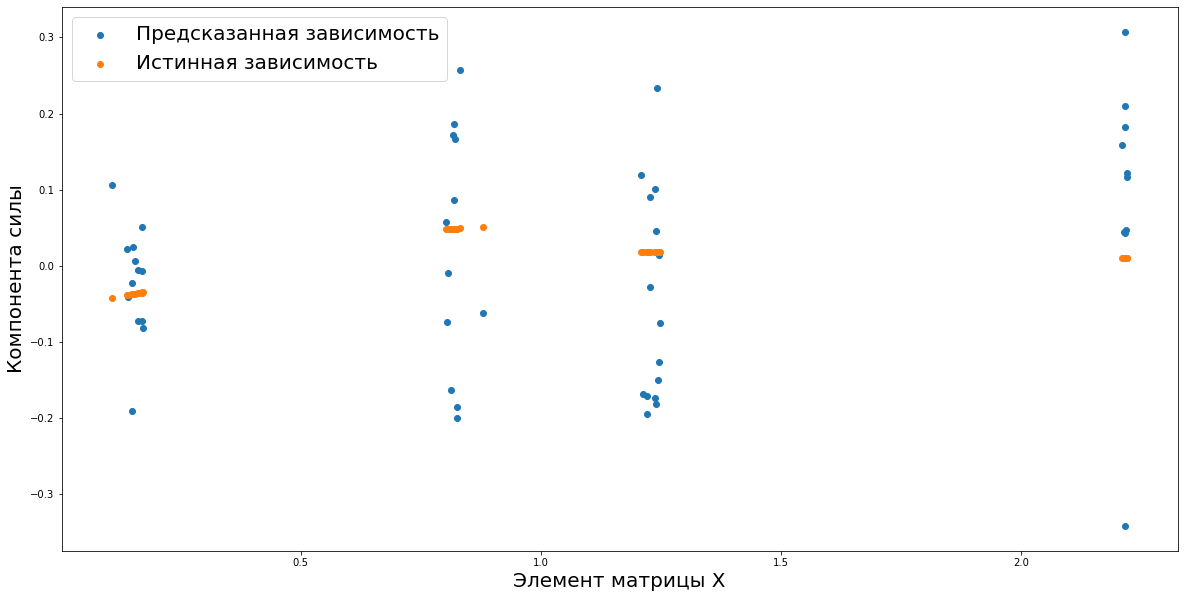

In [19]:
plot_2d_result(x11_val, Y_true, Y_pred, figsize=(20, 10))